# Lending Club: Modeling

### Six things for building the model are done in this notebook:     
* Select data: Get rid of null features, split train and test datasets in terms of issued time, select data with term of 36 months   
* Feature engineering and cleaning    
* XGBoost modeling: Preliminary     
* Tuning hyperparameters with Bayesian Optimization   
* Find out the most important predictors based on the tuned model
* Save the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from bayes_opt import BayesianOptimization
%matplotlib inline

#### Load Data

In [2]:
df1 = pd.read_csv('loan_2014.csv')

C:\Users\Tong\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1.shape

(235631, 105)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Columns: 105 entries, percentbcgt75 to loanstatus
dtypes: float64(85), object(20)
memory usage: 188.8+ MB


## 1. Select Data

### 1.1 Select categorical and numeric features which are not null

In [5]:
df1.count()

percentbcgt75                 233072
emptitle                      222393
mthssincerecentrevoldelinq     84766
verificationstatusjoint            0
mthssincercntil                    0
openactil                          0
loanamnt                      235629
desc                           15279
collections12mthsexmed        235629
pubrecbankruptcies            235629
numactvrevtl                  235629
memberid                           0
term                          235629
taxliens                      235629
totalcutl                          0
numiltl                       235629
secappopenactil                    0
totalrevhilim                 235629
delinq2yrs                    235629
accnowdelinq                  235629
allutil                            0
avgcurbal                     235623
dti                           235629
accopenpast24mths             235629
numbctl                       235629
numtl120dpd2m                 227769
revolbal                      235629
t

In [6]:
# get all_null_feature from EDA
all_null_feature = [
                    'verificationstatusjoint',
                    'mthssincercntil',
                    'openactil',
                    'memberid',
                    'totalcutl',
                    'secappopenactil',
                    'allutil',
                    'secappinqlast6mths',
                    'secappchargeoffwithin12mths',
                    'secapprevolutil',
                    'inqlast12m',
                    'secappmortacc',
                    'openrv12m',
                    'secappcollections12mthsexmed',
                    'openacc6m',
                    'secappopenacc',
                    'revolbaljoint',
                    'secappnumrevaccts',
                    'secappmthssincelastmajorderog',
                    'maxbalbc',
                    'openil24m',
                    'secappearliestcrline',
                    'annualincjoint',
                    'dtijoint',
                    'openil12m',
                    'inqfi',
                    'ilutil',
                    'totalbalil',
                    'openrv24m'
                    ]                 

In [7]:
cat_feature = [
               'emptitle',
               'desc',
               'term',
               'id',
               'zipcode',
               'intrate',
               'initialliststatus',
               'homeownership',
               'grade',
               'revolutil',
               'applicationtype',
               'emplength',
               'addrstate',
               'disbursementmethod',
               'subgrade',
               'earliestcrline',
               'purpose',
               'verificationstatus',
               'issued',
               'loanstatus'
               ]

In [8]:
num_feature = [
               'percentbcgt75',
               'mthssincerecentrevoldelinq',
               'loanamnt',
               'collections12mthsexmed',
               'pubrecbankruptcies',
               'numactvrevtl',
               'taxliens',
               'numiltl',
               'totalrevhilim',
               'delinq2yrs',
               'accnowdelinq',
               'avgcurbal',
               'dti',
               'accopenpast24mths',
               'numbctl',
               'numtl120dpd2m',
               'revolbal',
               'totcurbal',
               'totalacc',
               'openacc',
               'fundedamnt',
               'tothicredlim',
               'numsats',
               'mosinoldilacct',
               'mthssincelastdelinq',
               'delinqamnt',
               'totalbclimit',
               'chargeoffwithin12mths',
               'mthssincerecentinq',
               'numrevtlbalgt0',
               'numtl90gdpd24m',
               'mthssincelastmajorderog',
               'mthssincerecentbc',
               'totalbalexmort',
               'numacctsever120pd',
               'mosinrcntrevtlop',
               'mthssincerecentbcdlq',
               'numtl30dpd',
               'numtloppast12m',
               'mosinrcnttl',
               'numbcsats',
               'pcttlnvrdlq',
               'installment',
               'mortacc',
               'numactvbctl',
               'mosinoldrevtlop',
               'numrevaccts',
               'mthssincelastrecord',
               'pubrec',
               'bcopentobuy',
               'totcollamt',
               'inqlast6mths',
               'totalilhighcreditlimit',
               'annualinc',
               'bcutil',
               'numoprevtl'
               ]

In [9]:
select_feature=cat_feature+num_feature
len(select_feature)

76

### 1.2 Remove several features based on the data EDA

In [10]:
# remove applicationtype since it only has one value as 'individual'
# remove disbursementmethod since it only has one value as 'cash'
cat_feature.remove('applicationtype')
cat_feature.remove('disbursementmethod')

In [11]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan
num_feature.remove('fundedamnt')

In [12]:
# remove 'id','issued' and 'loanstatus' from cat_feature, since they are index, train/test flag and target
cat_feature.remove('id')
cat_feature.remove('loanstatus')
cat_feature.remove('issued')

In [13]:
# remove 'desc' from cat_feature
cat_feature.remove('desc')

In [14]:
select_feature=cat_feature+num_feature
len(select_feature)

69

In [15]:
# selected features left and delete the last two rows which are null for all features
df=df1[select_feature+['loanstatus','issued']][:-2]

In [16]:
df.shape

(235629, 71)

### 1.3 Select term = 36 months, loanstatus = fully paid and charged off

In [17]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [18]:
df = df.query("term ==' 36 months'")

In [19]:
df.shape

(162474, 71)

In [20]:
cat_feature.remove('term')

### 1.4 Label target (loanstatus) with 0 and 1

In [21]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [22]:
print (df.loanstatus.value_counts())
print (df.loanstatus.value_counts(normalize=True))

0    140202
1     22272
Name: loanstatus, dtype: int64
0    0.86292
1    0.13708
Name: loanstatus, dtype: float64


In [23]:
df.head()

,emptitle,term,zipcode,intrate,initialliststatus,homeownership,grade,revolutil,emplength,addrstate,...,pubrec,bcopentobuy,totcollamt,inqlast6mths,totalilhighcreditlimit,annualinc,bcutil,numoprevtl,loanstatus,issued
1,Truck Driver Delivery Personel,36 months,937xx,6.99%,w,MORTGAGE,A,31.6%,8 years,CA,...,0.0,7599.0,0.0,2.0,11325.0,58000.0,41.5,14.0,1,Dec-2014
3,Technical Specialist,36 months,850xx,13.66%,f,RENT,C,91.9%,< 1 year,AZ,...,0.0,332.0,0.0,1.0,64031.0,50000.0,93.2,4.0,1,Dec-2014
5,Admin Specialist,36 months,077xx,13.66%,f,RENT,C,59.4%,10+ years,NJ,...,0.0,6494.0,0.0,0.0,24890.0,69000.0,69.2,8.0,0,Dec-2014
7,Store Manager,36 months,208xx,11.44%,f,RENT,B,20.2%,2 years,MD,...,0.0,12152.0,0.0,0.0,6000.0,26000.0,26.8,6.0,0,Dec-2014
9,Investment Consultant,36 months,483xx,11.99%,f,RENT,B,98%,8 years,MI,...,0.0,324.0,0.0,1.0,0.0,90000.0,98.5,5.0,1,Dec-2014


### 1.5 Set Oct~Dec as test data and others as train data, based on issued

In [24]:
issued=list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [25]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts()

1    112548
0     49926
Name: train_flg, dtype: int64

## 2. Feature Engineering & Cleaning

### 2.1 Convert datetime to numeric feature

In [26]:
df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Aug-2002', 'Nov-1992', 'May-2009', 'Jul-2003'], dtype=object)

Convert to number of months to Dec 2014

In [27]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [28]:
cl_month.unique()

array(['Sep', 'Aug', 'Nov', 'May', 'Jul', 'Oct', 'Jan', 'Jun', 'Dec',
       'Feb', 'Apr', 'Mar'], dtype=object)

In [29]:
cl_year.unique()

array([1989, 2002, 1992, 2009, 2003, 2001, 1999, 1998, 1996, 1995, 1993,
       2010, 2007, 2006, 1994, 2000, 2008, 1988, 2004, 2011, 1997, 1984,
       2005, 1973, 1991, 1986, 1987, 1985, 1982, 1979, 1974, 1983, 1976,
       1990, 1978, 1981, 1980, 1977, 1969, 1971, 1967, 1972, 1968, 1962,
       1975, 1965, 1966, 1963, 1970, 1964, 1958, 1955, 1959, 1961, 1960,
       1954, 1957, 1949, 1950, 1948, 1953, 1956], dtype=int64)

In [30]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [31]:
df['earliestcrline_month']=df.earliestcrline.apply(lambda x: (2014-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [32]:
df.earliestcrline_month[:5]

1    303
3    148
5    265
7     67
9    137
Name: earliestcrline_month, dtype: int64

In [33]:
num_feature.append('earliestcrline_month')
cat_feature.remove('earliestcrline')

In [34]:
print (len(cat_feature), len(num_feature))

12 56


### 2.2 Convert emplength to numeric feature

In [35]:
print (df['emplength'].isnull().sum())
df['emplength'].unique()

9640


array(['8 years', '< 1 year', '10+ years', '2 years', '9 years', '7 years',
       nan, '3 years', '1 year', '5 years', '4 years', '6 years'], dtype=object)

In [36]:
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [37]:
df.emplength.value_counts()

 10     51112
 2      14656
 3      13100
 0      13051
 1      10565
 4       9662
-999     9640
 5       9146
 7       8936
 6       8203
 8       8128
 9       6275
Name: emplength, dtype: int64

In [38]:
num_feature.append('emplength')
cat_feature.remove('emplength')
print (len(cat_feature), len(num_feature))

11 57


### 2.3 Convert intrate, revolutil to numeric features: get rid of %

In [39]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [40]:
df.intrate=intrate
df.intrate[:2]

1     6.99
3    13.66
Name: intrate, dtype: float64

In [41]:
df.revolutil[:3]

1    31.6%
3    91.9%
5    59.4%
Name: revolutil, dtype: object

In [42]:
revolutil=df.revolutil.apply(lambda x: str(x).replace('%','')).astype(float)

In [43]:
df.revolutil=revolutil
df.revolutil[:2]

1    31.6
3    91.9
Name: revolutil, dtype: float64

In [44]:
cat_feature.remove('intrate')
num_feature.append('intrate')
cat_feature.remove('revolutil')
num_feature.append('revolutil')

In [45]:
print (len(cat_feature), len(num_feature))

9 59


### 2.4 Convert grade, subgrade to ordinal features

In [46]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [47]:
df.grade = df.grade.map(Dic_grade)

In [48]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [49]:
cat_feature.remove('grade')
num_feature.append('grade')
cat_feature.remove('subgrade')
num_feature.append('subgrade')

In [50]:
print (len(cat_feature), len(num_feature))

7 61


### 2.5 Convert high cardinality features

###### Zip Code - frequency encoding 

In [51]:
print (df.zipcode.nunique(), df.zipcode.unique()[:5])

854 ['937xx' '850xx' '077xx' '208xx' '483xx']


In [52]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [53]:
df.zipcode[:5]

1    937
3    850
5     77
7    208
9    483
Name: zipcode, dtype: int64

In [54]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [55]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,229
2,11,66
3,12,69
4,13,41


In [56]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [57]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [58]:
df.zipcode_freq[:5]

0    243
1    735
2    365
3    434
4    572
Name: zipcode_freq, dtype: int64

In [59]:
cat_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')
print (len(cat_feature), len(num_feature))

6 63


###### Emptitle - frequency encoding

In [60]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")

In [61]:
cat_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print (len(cat_feature), len(num_feature))

5 64


###### Addrstate - frequency encoding

In [62]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")

In [63]:
cat_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print (len(cat_feature), len(num_feature))

4 65


#### One hot encoding

In [64]:
cat_feature

['initialliststatus', 'homeownership', 'purpose', 'verificationstatus']

In [65]:
dummy_feature = cat_feature

In [66]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [67]:
OHE_feature=list(df_dummy.columns.values)

In [68]:
len(OHE_feature)

22

In [69]:
df=pd.concat([df,df_dummy], axis=1 )

In [70]:
df.shape

(162474, 98)

In [75]:
for feat in dummy_feature:    
    cat_feature.remove(feat)

In [76]:
len(cat_feature)

0

In [77]:
select_feature=num_feature+OHE_feature

In [78]:
len(select_feature)

87

##  3. XGBoost modeling: Preliminary

In [79]:
feat=select_feature
print (feat)

['percentbcgt75', 'mthssincerecentrevoldelinq', 'loanamnt', 'collections12mthsexmed', 'pubrecbankruptcies', 'numactvrevtl', 'taxliens', 'numiltl', 'totalrevhilim', 'delinq2yrs', 'accnowdelinq', 'avgcurbal', 'dti', 'accopenpast24mths', 'numbctl', 'numtl120dpd2m', 'revolbal', 'totcurbal', 'totalacc', 'openacc', 'tothicredlim', 'numsats', 'mosinoldilacct', 'mthssincelastdelinq', 'delinqamnt', 'totalbclimit', 'chargeoffwithin12mths', 'mthssincerecentinq', 'numrevtlbalgt0', 'numtl90gdpd24m', 'mthssincelastmajorderog', 'mthssincerecentbc', 'totalbalexmort', 'numacctsever120pd', 'mosinrcntrevtlop', 'mthssincerecentbcdlq', 'numtl30dpd', 'numtloppast12m', 'mosinrcnttl', 'numbcsats', 'pcttlnvrdlq', 'installment', 'mortacc', 'numactvbctl', 'mosinoldrevtlop', 'numrevaccts', 'mthssincelastrecord', 'pubrec', 'bcopentobuy', 'totcollamt', 'inqlast6mths', 'totalilhighcreditlimit', 'annualinc', 'bcutil', 'numoprevtl', 'earliestcrline_month', 'emplength', 'intrate', 'revolutil', 'grade', 'subgrade', 'zip

### Preliminary manually parameter tuning

In [121]:
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import train_test_split

In [80]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )

In [81]:
print (df_train.shape, df_test.shape)

(112548, 98) (49926, 98)


In [125]:
df_train[feat].shape

(112548, 87)

In [122]:
X_train, y_train = df_train[feat], df_train.loanstatus

In [123]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [124]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [126]:
metric = "auc"
default_xgb_params = {}
default_xgb_params["objective"] = "binary:logistic"
default_xgb_params["eta"] = 0.10
default_xgb_params["booster"] = "gbtree"
default_xgb_params["seed"] = 1234
default_xgb_params["metric"] = metric

params_xgb_space = {}
params_xgb_space['max_depth'] = [4,5,6,7,8,9,10]
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['subsample'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]

greater_is_better = True

In [127]:
best_xgb_params = default_xgb_params
for p in params_xgb_space:
    print ("Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('    %s: %s' % (p, v), end="")
        params[p] = v
        cv_results = xgb.cv(params, 
                            dtrain,
                            nfold=4,   
                            num_boost_round=2000,
                            early_stopping_rounds=50,
                            metrics=metric,
                            stratified=True,
                            shuffle=True, 
                            verbose_eval=False)    
        best_iteration = len(cv_results)
        if greater_is_better:
            best_score = cv_results['test-'+metric+'-mean'].max()
        else:
            best_score = cv_results['test-'+metric+'-mean'].min()
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

Tuning parameter max_depth in [4, 5, 6, 7, 8, 9, 10]
    max_depth: 4, best_score: 0.689136, best_iteration: 192
    max_depth: 5, best_score: 0.688072, best_iteration: 123
    max_depth: 6, best_score: 0.685720, best_iteration: 89
    max_depth: 7, best_score: 0.684310, best_iteration: 77
    max_depth: 8, best_score: 0.682142, best_iteration: 58
    max_depth: 9, best_score: 0.678605, best_iteration: 54
    max_depth: 10, best_score: 0.677304, best_iteration: 60
Best max_depth is 4 with a score of 0.689136
Tuning parameter gamma in [0, 0.1, 0.3, 1, 1.5, 2, 3]
    gamma: 0, best_score: 0.689136, best_iteration: 192
    gamma: 0.1, best_score: 0.689008, best_iteration: 190
    gamma: 0.3, best_score: 0.688862, best_iteration: 166
    gamma: 1, best_score: 0.688929, best_iteration: 189
    gamma: 1.5, best_score: 0.689542, best_iteration: 175
    gamma: 2, best_score: 0.689008, best_iteration: 156
    gamma: 3, best_score: 0.688882, best_iteration: 180
Best gamma is 1.5 with a score of 

## 4. Tuning Hyperparameters with Bayesian Optimization

### 4.1 Model tuning and evaluation

In [129]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.10
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['seed'] = 1234    
    

    cv_results = xgb.cv(params, 
                        dtrain,
                        nfold=4,   
                        num_boost_round=2000,
                        early_stopping_rounds=50,
                        metrics=metric,
                        stratified=True,
                        shuffle=True,  
                        verbose_eval=False)    
    best_iteration = len(cv_results)
    if greater_is_better:
        best_score = cv_results['test-'+metric+'-mean'].max()
    else:
        best_score = -cv_results['test-'+metric+'-mean'].min()
    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return best_score


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (3, 8),
                              'min_child_weight': (0, 200),
                              'colsample_bytree': (0.1, 0.7),
                              'subsample': (0.5, 1),
                              'gamma': (0, 3)
                             }
                            )

gp_params = {"alpha": 1e-4}
xgb_BO.maximize(init_points=5, n_iter=40, **gp_params)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
, best_score: 0.689646, best_iteration: 306
    1 | 01m03s |    0.68965 |             0.1411 |    0.5545 |      4.8459 |           179.8986 |      0.7155 | 
, best_score: 0.690458, best_iteration: 140
    2 | 01m27s |    0.69046 |             0.3386 |    2.6211 |      7.7138 |           178.7683 |      0.8358 | 
, best_score: 0.689283, best_iteration: 122
    3 | 01m01s |    0.68928 |             0.1876 |    2.9950 |      7.5159 |           149.9139 |      0.8926 | 
, best_score: 0.690281, best_iteration: 216
    4 | 01m51s |    0.69028 |             0.4853 |    2.1831 |      4.5340 |           157.8239 |      0.6749 | 
, best_score: 0.688699, best_iteration: 146
    5 | 00m56s |    0.68870 |             0.2042 |    2.0890 |      5.9647 |            

#### Display tuning results

In [132]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores[:5]

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
12,0.422818,2.221431,3.008174,199.995817,0.812466,0.691342
18,0.455535,0.667496,3.202454,199.992415,0.863513,0.691254
2,0.561707,1.601227,3.534461,199.982414,0.951295,0.691219
7,0.422639,0.281223,3.074517,199.989994,0.634084,0.691169
36,0.523079,0.934374,3.087949,199.986356,0.940650,0.691123


### 4.2 Retrain the model and draw the ROC curve

In [136]:
best_xgb_params = xgb_BO_scores.iloc[0].to_dict()
best_xgb_params['objective'] = 'binary:logistic'
best_xgb_params['eta'] = 0.01  # Smaller
best_xgb_params['booster'] = 'gbtree' 

best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['min_child_weight'] = best_xgb_params['min_child_weight']
best_xgb_params['subsample'] = best_xgb_params['subsample']
best_xgb_params['colsample_bytree'] = best_xgb_params['colsample_bytree']
best_xgb_params['gamma'] = best_xgb_params['gamma']
best_xgb_params['seed'] = 1234

print (best_xgb_params)

model = xgb.train(best_xgb_params, 
                  dtrain, 
                  num_boost_round=best_xgb_iteration)    

{'colsample_bytree': 0.4228184821502302, 'gamma': 2.221430786700525, 'max_depth': 3, 'min_child_weight': 199.99581724736368, 'subsample': 0.8124661057820475, 'score': 0.6913417500000001, 'objective': 'binary:logistic', 'eta': 0.01, 'booster': 'gbtree', 'seed': 1234}


In [135]:
model

In [137]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model #, datasets
import pylab as pl
def draw_ROC(model, dtrain, dtest, y_train, y_test):    
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)    
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)    
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print ("Area under the ROC curve - train: %f" % roc_auc_1)
    print ("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))    
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test(AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()

#### ROC curve

Area under the ROC curve - train: 0.676741
Area under the ROC curve - test: 0.687094


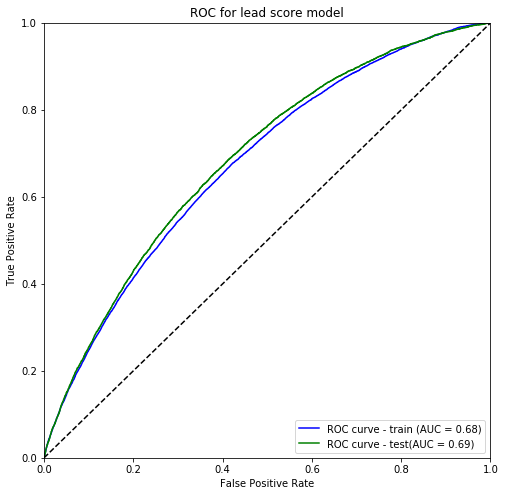

In [138]:
draw_ROC(model, dtrain, dtest, y_train, y_test)

#### Distribution of predicted values

In [139]:
y_pred = model.predict(dtest)
print (y_pred.max(), y_pred.min(), y_pred.mean())

0.314763 0.0725617 0.16654


# 5. Feature Importance

In [144]:
importance=model.get_fscore()

In [155]:
df_importance = pd.DataFrame(list(importance.items()), columns=['feature', 'fscore'])

** Display features and their relative importance in table, from the most to the least important **

In [157]:
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
1,intrate,0.176364
0,subgrade,0.164848
12,annualinc,0.093939
15,dti,0.070303
7,grade,0.066061
2,avgcurbal,0.060000
17,accopenpast24mths,0.058788
3,tothicredlim,0.036970
10,installment,0.033333
20,mosinoldrevtlop,0.024242


** Plot the relative importance of all features **

Text(0.5,0,'relative importance')

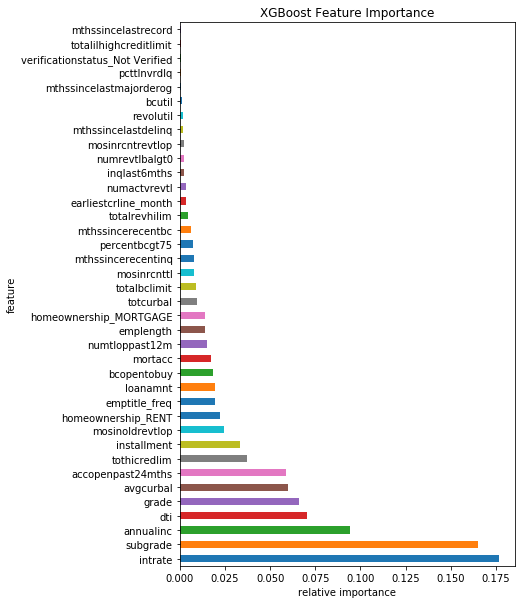

In [160]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

** Plot the relative importance of the 20 most important features **

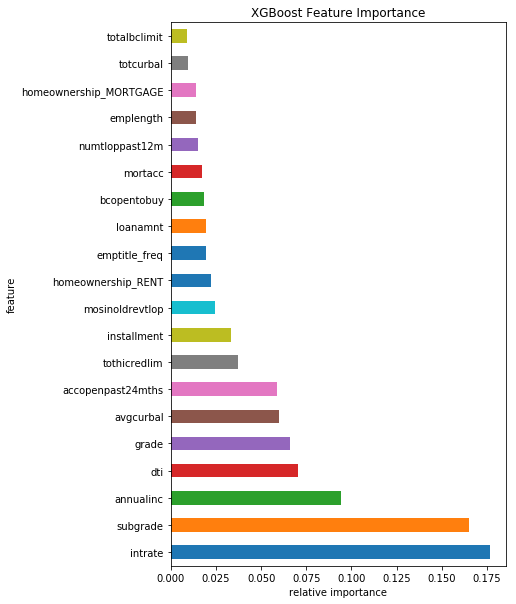

In [161]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [162]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
7,grade,0.066061


In [163]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
0,subgrade,0.164848


In [131]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
59,intrate,0.030945


# 6. Save the model

In [164]:
import pickle

In [167]:
with open('model.pkl', 'wb') as outfile:  
    pickle.dump(model, outfile)